In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc
from tools.mlr import mlr
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
import read_stuff as read
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_2917212/753694454.py:18: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [3]:
from tqdm.auto import tqdm
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

  0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
import importlib
importlib.reload(read)

<module 'read_stuff' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/read_stuff.py'>

In [5]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading input and outpus                    
└──────────────────────────────────────────────────────────────────────────"""
#Xtrain,Xvalid,Xtest,yall,yall_orig = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').read_Xy(num=33,needorig=False)
Xtrain,Xvalid,Xtest,yall = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').read_Xy(num=33,needorig='No')
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading PC structures for custom loss                       
└──────────────────────────────────────────────────────────────────────────"""
pcastore = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').pcastore
#wcomps = [26,18,48,14]
#upcs,vpcs,wpcs,thpcs = pcastore['u'].components_[:wcomps[0]],pcastore['v'].components_[:wcomps[1]],pcastore['w'].components_[:wcomps[2]],pcastore['theta'].components_[:wcomps[3]]
wcomps = [50,38,8]
upcs,vpcs,thpcs = pcastore['u'].components_[:wcomps[0]],pcastore['v'].components_[:wcomps[1]],pcastore['theta'].components_[:wcomps[2]]
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading y truth for custom loss                      
└──────────────────────────────────────────────────────────────────────────"""
#yTRUTH = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').y_truth(divider=divider,lti=24,num=33,withW=False)

  0%|          | 0/33 [00:00<?, ?it/s]

'──────────────────────────────────────────────────────────────────────────┐\n│ Loading y truth for custom loss                      \n└──────────────────────────────────────────────────────────────────────────'

In [16]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Which split will we be testing                     
└──────────────────────────────────────────────────────────────────────────"""
splitnum = 5

### PyTorch

#### Data processing

In [17]:
X_totrain,y_totrain = train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtrain[splitnum]['lwswdtthuvwqv'],yall_orig[splitnum][23][0])#yall_orig[splitnum][23][0])
X_tovalid,y_tovalid = train_optimizedMLR(folderpath,folderpath2).delete_padding(Xvalid[splitnum]['lwswdtthuvwqv'],yall_orig[splitnum][23][1])#yall_orig[splitnum][23][1])
X_totest,y_totest = train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtest[splitnum]['lwswdtthuvwqv'],yall_orig[splitnum][23][2])#yall_orig[splitnum][23][2])

In [18]:
calc_device = 'cpu'
###################################################################################
# Convert numpy arrays into tensors
###################################################################################
train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)

val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)

test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
test_ytensor = torch.FloatTensor(y_totest).to(calc_device)

train_data = torch.utils.data.TensorDataset(train_Xtensor, train_ytensor)
val_data = torch.utils.data.TensorDataset(val_Xtensor, val_ytensor)
test_data = torch.utils.data.TensorDataset(test_Xtensor, test_ytensor)

###################################################################################
# Eigenvectors for Custom Loss in Physical Space
###################################################################################
eigenvectors = [torch.FloatTensor(obj).to(calc_device) for obj in [upcs,vpcs,wpcs,thpcs]]
###################################################################################
# Variances to calculate r2 in Physical Space
###################################################################################
varu,varv,varw,varth = np.var(yTRUTH['train'][splitnum]['du']),np.var(yTRUTH['train'][splitnum]['dv']),np.var(yTRUTH['train'][splitnum]['dw']),np.var(yTRUTH['train'][splitnum]['dth'])

#### Hyperparameters for training

In [9]:
batch_size = 9
num_workers = 2

#### DataLoader

In [10]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_data,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False
)

#### Define Model Architecture

In [5]:
brchindex = [0,30,60,60+52,60+52+60]
brchsize = [30,30,52,60]

##### LW/SW

In [5]:
class OptimMLR_all_3D_simple(torch.nn.Module):
    def __init__(self):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_all_3D_simple, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [20,20]#[50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        #self.dense3 = torch.nn.Linear(brchsize[2], 1)
        #self.dense4 = torch.nn.Linear(brchsize[3], 1)
        #self.dense5 = torch.nn.Linear(brchsize[4], 1)
        #self.dense6 = torch.nn.Linear(brchsize[5], 1)
        #self.dense7 = torch.nn.Linear(brchsize[6], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(2,96)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,50,38,91,8,82,20,20]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestlw = self.dense1(X_lw)
        bestsw = self.dense2(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

##### LW/SW/HDIA

In [12]:
class OptimMLR_all_3D_simple_lwswhdia(torch.nn.Module):
    def __init__(self):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_all_3D_simple_lwswhdia, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [82,20,20]#[50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        #self.dense4 = torch.nn.Linear(brchsize[3], 1)
        #self.dense5 = torch.nn.Linear(brchsize[4], 1)
        #self.dense6 = torch.nn.Linear(brchsize[5], 1)
        #self.dense7 = torch.nn.Linear(brchsize[6], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(3,96)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,50,38,91,8,82,20,20]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        besthdia = self.dense1(X_hdia)
        bestlw = self.dense2(X_lw)
        bestsw = self.dense3(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((besthdia,bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

##### LW/SW/U

In [6]:
class OptimMLR_all_3D_simple_lwswu(torch.nn.Module):
    def __init__(self):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_all_3D_simple_lwswu, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [50,20,20]#[50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        #self.dense4 = torch.nn.Linear(brchsize[3], 1)
        #self.dense5 = torch.nn.Linear(brchsize[4], 1)
        #self.dense6 = torch.nn.Linear(brchsize[5], 1)
        #self.dense7 = torch.nn.Linear(brchsize[6], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(3,96)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,50,38,91,8,82,20,20]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestu = self.dense1(X_u)
        bestlw = self.dense2(X_lw)
        bestsw = self.dense3(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestu,bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

##### All

In [5]:
class OptimMLR_all_3D_simple(torch.nn.Module):
    def __init__(self):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_all_3D_simple, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        self.dense4 = torch.nn.Linear(brchsize[3], 1)
        self.dense5 = torch.nn.Linear(brchsize[4], 1)
        self.dense6 = torch.nn.Linear(brchsize[5], 1)
        self.dense7 = torch.nn.Linear(brchsize[6], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(7,96)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,50,38,91,8,82,20,20]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestu = self.dense1(X_u)
        bestv = self.dense2(X_v)
        bestw = self.dense3(X_w)
        bestth = self.dense4(X_th)
        besthdia = self.dense5(X_hdia)
        bestlw = self.dense6(X_lw)
        bestsw = self.dense7(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestu,bestv,bestw,bestth,besthdia,bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

#### All channels

In [6]:
class OptimMLR_all_2D(torch.nn.Module):
    def __init__(self):
        super(OptimMLR_all_2D, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [26*2,18*2,48+12,14*2,9*2,6*3,30,30]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        self.dense4 = torch.nn.Linear(brchsize[3], 1)
        self.dense5 = torch.nn.Linear(brchsize[4], 1)
        self.dense6 = torch.nn.Linear(brchsize[5], 1)
        self.dense7 = torch.nn.Linear(brchsize[6], 1)
        self.dense8 = torch.nn.Linear(brchsize[7], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(8,106)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,26*2,18*2,48+12,14*2,9*2,6*3,30,30]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_rh, X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]],X[:,brchindex[7]:brchindex[8]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestu = self.dense1(X_u)
        bestv = self.dense2(X_v)
        bestw = self.dense3(X_w)
        bestth = self.dense4(X_th)
        bestrh = self.dense5(X_rh)
        besthdia = self.dense6(X_hdia)
        bestlw = self.dense7(X_lw)
        bestsw = self.dense8(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestu,bestv,bestw,bestth,bestrh,besthdia,bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

In [11]:
from torchviz import make_dot
make_dot(mymodel(torch.rand((819,60))),params=dict(mymodel.named_parameters()))

NameError: name 'mymodel' is not defined

##### Custom Losses

In [7]:
class R2Loss(torch.nn.Module):
    
    def forward(self, y_pred, y):
        var_y = torch.var(y, unbiased=False)
        return -(1.0 - torch.nn.functional.mse_loss(y_pred, y, reduction="mean") / var_y)
    
class MSE_physicalLoss(torch.nn.Module):
    def __init__(self, pcs=None, wantcomps=None, variances=None):
        super(MSE_physicalLoss, self).__init__()
        self.pcs = pcs
        self.wantcomps = wantcomps
        self.variances = variances
        
    def forward(self, y_pred, y):
        def myscore(y_pred, y, var_y):
            return torch.mean(torch.square(y - y_pred).sum()).div(var_y)
            #var_y = torch.var(y, unbiased=False)
            #return (torch.nn.functional.mse_loss(y_pred, y, reduction="mean") / var_y) #mse/var
        """
        1. Here we slice the feature axis to separate samples into u/v/w/theta components
        """
        y_pred_u, y_u = y_pred[:,0:self.wantcomps[0]], y[:,0:self.wantcomps[0]]
        y_pred_v, y_v = y_pred[:,self.wantcomps[0]:self.wantcomps[0]+self.wantcomps[1]], y[:,self.wantcomps[0]:self.wantcomps[0]+self.wantcomps[1]]
        y_pred_w, y_w = y_pred[:,self.wantcomps[0]+self.wantcomps[1]:self.wantcomps[0]+self.wantcomps[1]+self.wantcomps[2]], \
        y[:,self.wantcomps[0]+self.wantcomps[1]:self.wantcomps[0]+self.wantcomps[1]+self.wantcomps[2]]
        y_pred_th, y_th = y_pred[:,self.wantcomps[0]+self.wantcomps[1]+self.wantcomps[2]:self.wantcomps[0]+self.wantcomps[1]+self.wantcomps[2]+self.wantcomps[3]], \
        y[:,self.wantcomps[0]+self.wantcomps[1]+self.wantcomps[2]:self.wantcomps[0]+self.wantcomps[1]+self.wantcomps[2]+self.wantcomps[3]]
        """
        2. Here we convert PCs into physical space
        """
        uphys_pred, uphys_real = torch.matmul(y_pred_u, self.pcs[0]),torch.matmul(y_u, self.pcs[0])
        vphys_pred, vphys_real = torch.matmul(y_pred_v, self.pcs[1]),torch.matmul(y_v, self.pcs[1])
        wphys_pred, wphys_real = torch.matmul(y_pred_w, self.pcs[2]),torch.matmul(y_w, self.pcs[2])
        thphys_pred, thphys_real = torch.matmul(y_pred_th, self.pcs[3]),torch.matmul(y_th, self.pcs[3])
        
        u_mse, v_mse, w_mse, th_mse = myscore(uphys_pred,uphys_real,self.variances[0]),myscore(vphys_pred,vphys_real,self.variances[1]),\
        myscore(wphys_pred,wphys_real,self.variances[2]),myscore(thphys_pred,thphys_real,self.variances[3])
        
        msesum = u_mse+v_mse+w_mse+th_mse
        return msesum/4#, u_mse,v_mse,w_mse,th_mse

#### Model compile settings

In [46]:
from torchsummary import summary
summary(model,input_size=(channels, H, W))

NameError: name 'channels' is not defined

#### Evaluation Loop

In [8]:
def eval_model(model, dataloader, loss_func, metric_func):
    with torch.no_grad():
        loss = 0
        metric = 0
        
        global_sum = 0
        label_size = 0
        for feature, labels in dataloader:
            global_sum += labels.sum()
            label_size += len(labels)
            
        global_mean = global_sum / label_size
        for features, labels in dataloader:
            pred = model(features)
            batch_loss = loss_func(pred, labels)
            batch_metric = metric_func(pred, labels, global_mean)
            
            loss+=batch_loss.item()
            metric+=batch_metric.item()
            
        num_batches = len(dataloader)
        
        loss = loss/num_batches
        metric = metric/num_batches
        return (loss, metric)
    
# Customzied evaluation metric NSE for validation set and test set # 
def calc_nse(sim: torch.FloatTensor, obs: torch.FloatTensor, global_obs_mean: torch.FloatTensor) -> float:
    """Calculate the Nash-Sutcliff-Efficiency coefficient.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :param global_obs_mean: mean of the whole observation series
    :return: NSE value.
    """
    numerator = torch.square(sim - obs).sum()
    #denominator = torch.square(obs - global_obs_mean).sum()
    #nse_val = 1 - numerator / denominator

    return numerator

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            #self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [9]:
from livelossplot import PlotLosses

In [10]:
def train_model(optimizer=None,scheduler=None,numepochs=None,early_stopper=None,variance_store=None,lossfunc=None,regularization='None',l1_lambda=0.01):
    # Custom loss: MSE_physicalLoss(eigenvectors,wcomps,variance_store)
    liveloss = PlotLosses()
    schedulerCY,schedulerLS = scheduler[1],scheduler[0]
    train_losses,trainu_losses,trainv_losses,trainw_losses,trainth_losses = [],[],[],[],[]
    val_losses = []
    val_NSEs = []
    for epoch in tqdm(range(int(num_epochs))):
        """
        Initialize loss
        """
        train_loss = 0
        """
        Operate per batch
        """
        for features, labels in train_loader:
            optimizer.zero_grad()
            
            prediction = model(features)
            batch_loss = lossfunc(prediction, labels)#loss_func(prediction, labels)
            
            if regularization=='L1':
                #L1 regularization-------------------------------
                l1_norm = sum(abs(p) for p in model.parameters())
                #-------------------------------------------------
                batch_loss = batch_loss + l1_lambda * l1_norm
                batch_loss.backward()
            elif regularization=='None':
                batch_loss.backward()                
            
            optimizer.step()
            schedulerCY.step()
            
            train_loss += batch_loss.item()
            
            
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        val_loss, val_NSE = eval_model(model,
                                       val_loader,
                                       lossfunc,
                                       calc_nse)
        schedulerLS.step(val_loss)
        
        ##################################################################
        # Early Stopping (valid / train)
        ##################################################################
        counter = 0
        if len(val_losses)>=1:
            best_score = val_losses[-1]
            if val_loss > best_score:
                counter += 1
                val_NSEs.append(val_NSE)
                val_losses.append(val_loss)
                if counter >= 10:
                    break
            else:
                val_NSEs.append(val_NSE)
                val_losses.append(val_loss)
        else:
            val_NSEs.append(val_NSE)
            val_losses.append(val_loss)
        
        if early_stopper.__call__(val_loss, model):
            break
        #if early_stopper.early_stop(val_loss):             
        #    break
            ##################################################################
        #val_NSEs.append(val_NSE)
        #val_losses.append(val_loss)
        
        if epoch % 500 == 0:
            print((np.log10(train_loss),np.log10(val_loss)))
            
    #return model, {'train':train_losses,'utrain':trainu_losses,'vtrain':trainv_losses,'wtrain':trainw_losses,'thtrain':trainth_losses,'val':val_losses} 
    return model, {'train':train_losses,'val':val_losses} 

In [ ]:
#splitnum = 5
from livelossplot import PlotLosses
for splitnum in range(33):
    X_totrain,y_totrain = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtrain[splitnum]['lwswdtthuvw'],yall[splitnum][23][0])#yall_orig[splitnum][23][0])
    X_tovalid,y_tovalid = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xvalid[splitnum]['lwswdtthuvw'],yall[splitnum][23][1])#yall_orig[splitnum][23][1])
    X_totest,y_totest = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtest[splitnum]['lwswdtthuvw'],yall[splitnum][23][2])#yall_orig[splitnum][23][2])
    calc_device = 'cpu'
    ###################################################################################
    # Convert numpy arrays into tensors
    ###################################################################################
    train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
    train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)
    val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
    val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)
    test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
    test_ytensor = torch.FloatTensor(y_totest).to(calc_device)
    train_data = torch.utils.data.TensorDataset(train_Xtensor, train_ytensor)
    val_data = torch.utils.data.TensorDataset(val_Xtensor, val_ytensor)
    test_data = torch.utils.data.TensorDataset(test_Xtensor, test_ytensor)
    ###################################################################################
    # Eigenvectors for Custom Loss in Physical Space
    ###################################################################################
    #eigenvectors = [torch.FloatTensor(obj).to(calc_device) for obj in [upcs,vpcs,thpcs]]#[upcs,vpcs,wpcs,thpcs]]
    ###################################################################################
    # Variances to calculate r2 in Physical Space
    ###################################################################################
    #varu,varv,varw,varth = np.var(yTRUTH['train'][splitnum]['du']),np.var(yTRUTH['train'][splitnum]['dv']),np.var(yTRUTH['train'][splitnum]['dw']),np.var(yTRUTH['train'][splitnum]['dth'])
    #varu,varv,varth = np.var(yTRUTH['train'][splitnum]['du']),np.var(yTRUTH['train'][splitnum]['dv']),np.var(yTRUTH['train'][splitnum]['dth'])
    batch_size = 9
    num_workers = 2
    train_loader = torch.utils.data.DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=val_data,
        batch_size=batch_size,
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=False
    )
    
    times = ['exp1a','exp1b','exp1c','exp1d','exp1e']
    #times = ['exp2a','exp2b','exp2c']#,'exp1d','exp1e']
    for i in range(len(times)):
        models,losses = [],[]
        #model = OptimMLR_all_2D()
        model = OptimMLR_all_3D_simple_lwswu()
        optimizers = [torch.optim.Adam(model.parameters(), lr=1e-7)]#, optim.AdaBound(model.parameters(),lr=1e-7)] 1e-6
        loss = torch.nn.MSELoss()
        for optimizer in optimizers:
            scheduler2 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-9, max_lr=1e-5,cycle_momentum=False)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=1e-18)
            num_epochs = 1000*18#26
            early_stopper = EarlyStopping(patience=50, verbose=False, delta=1e-7, path='checkpoint.pt', trace_func=print)#EarlyStopper(patience=8, min_delta=1e-3)
            #variance_store = [varu,varv,varw,varth]
            #variance_store = [varu,varv,varth]
            model,loss = train_model(optimizer=optimizer,scheduler=[scheduler,scheduler2],numepochs=num_epochs,early_stopper=early_stopper,variance_store=None,\
                                     lossfunc=loss)
            models.append(model)
            losses.append(loss)
        torch.save(models, './tmp/torch_try/lwswu/0/models'+str(splitnum)+'_LWSW3d_1115_'+str(times[i])+'.pt')
        read_and_proc.save_to_pickle('./tmp/torch_try/lwswu/0/losses'+str(splitnum)+'_LWSW3d_1115_'+str(times[i])+'.pkt',losses,'PICKLE')

/tmp/ipykernel_2917212/774246948.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660136119739/work/torch/csrc/utils/tensor_new.cpp:201.)
  train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6503260043919548, -0.6604299084408924)
(-1.6229724622539572, -1.4148419126452894)
(-3.512220409639173, -2.658729616697235)
(-4.54083833803565, -4.33718945237904)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6779086175272405, -0.8213534438856824)
(-1.6524588280139079, -1.595048407703919)
(-3.6296485458464387, -2.834679078081171)
(-4.522542766053208, -3.9447368550539115)
(-4.579691501323035, -4.545419759193684)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6679451976343127, -0.6877036517506331)
(-1.8470510426967706, -1.5754502094882181)
(-4.031040955581344, -2.634835994839523)
(-4.408101037062195, -3.404041478431143)
(-4.556821577810286, -4.206933960483049)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6839886212948543, -0.705366265597882)
(-1.733831580806574, -1.4752402794215835)
(-4.066803841118073, -2.8746322225499457)
(-4.577167443233843, -4.547229783393345)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6608006564376622, -0.6986304480890904)
(-1.6601377297893927, -1.520514696757698)
(-3.366234351606475, -2.8050411915118163)
(-4.462912128718884, -3.9286693218395072)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.703675965639945, -0.6010624907440327)
(-1.7591415437319908, -1.2329420786227385)
(-3.512468377226231, -1.9937785360538895)
(-4.473562596651571, -3.428874123326325)
(-4.583558984833807, -4.575735573347036)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7134941952868085, -0.525395225827878)
(-1.7354694548992973, -1.3789190100769084)
(-3.6443105852722377, -2.5252177861714844)
(-4.434886623936792, -3.733899954339989)
(-4.56982105361091, -4.393288515712733)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7319905943197216, -0.6533431099991056)
(-1.9779232800008462, -1.6521286338061811)
(-4.1222859421528275, -3.757966109354508)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6606889525904561, -0.5737407140551055)
(-1.606472244171939, -1.41740732317855)
(-3.583546768321465, -2.717864990022285)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7029625330029443, -0.6892633731613607)
(-1.653883806832082, -1.5717003000067635)
(-4.070770254158108, -3.4481004801213766)
(-4.568890535868152, -4.452296035700604)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6331398484196203, -0.6376382228641636)
(-1.6361837885180095, -1.5419038686051645)
(-3.6118151192667334, -3.1935291358859126)
(-4.472704790730369, -3.960219839694154)
(-4.575246251097282, -4.4663418169262235)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6138303052805687, -0.6345443636067192)
(-1.5456977798560374, -1.4125988768592228)
(-3.7045284977106903, -2.9465299432711225)
(-4.580196297213751, -4.490961565891997)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6870497845292599, -0.6378540273730787)
(-1.7683642856814104, -1.530737257344447)
(-3.563724552041502, -2.8471720815223653)
(-4.581607320105544, -4.505577995624914)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6260192582719639, -0.5206389007443233)
(-1.5421354634091062, -1.391900287434848)
(-3.3014183928465615, -3.152484569688181)
(-4.577631773478296, -4.509882477954238)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6543117375005484, -0.5793999606819928)
(-1.710196784527216, -1.572160181337924)
(-3.680739573367161, -2.7528763597493118)
(-4.333933633189584, -3.41240938633934)
(-4.524744807881126, -4.047597321768103)
(-4.572894733371388, -4.518008372657436)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6953849880956504, -0.6119901903747043)
(-1.863183353763376, -1.6223244300400133)
(-4.166290090894949, -3.5056718932367525)
(-4.561802481587627, -4.492197839406374)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6198709246462136, -0.6616697119594941)
(-1.7682306544264073, -1.4512723730752037)
(-3.9001126164023026, -2.8452022164773987)
(-4.4754146968165465, -3.9370084132621272)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6980752063597508, -0.6980246769020377)
(-1.8490170360168736, -1.6349839328343205)
(-4.488266824429498, -3.9726944595722586)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6446241314723595, -0.5802244875279933)
(-1.6941456300636897, -1.4038653131022234)
(-4.091076917386044, -2.75545171165032)
(-4.584342715656662, -4.65274144001589)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6139446723792071, -0.631928348833112)
(-1.7202856973539284, -1.562824932969779)
(-4.216989096987602, -3.4736159181349815)
(-4.5744673627853185, -4.513823512131928)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6619099908617678, -0.6018202283415073)
(-1.781004880341774, -1.6786720138307638)
(-4.157856380776111, -3.3317011397175906)
(-4.5074328088770095, -3.927732161293325)
(-4.581550780120387, -4.598652148763549)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7018185748088528, -0.5996376288673961)
(-1.904408490333261, -1.6582372683588067)
(-4.0780445969257855, -3.1871917469581663)
(-4.556789217265644, -4.242042542081873)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7127667124338904, -0.8836790652310763)
(-1.8669353529043886, -1.7954798123677596)
(-4.484782135261219, -4.049906124368475)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6223964666711527, -0.5859627943444381)
(-1.5949963726783198, -1.5753893227784312)
(-3.8257688637321285, -3.393245114531869)
(-4.5863533696897525, -4.595855904368306)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6625421397767508, -0.6578892270563536)
(-1.9010512357183194, -1.7427357933468592)
(-4.463632534433474, -3.7252427318319277)
(-4.582041392641761, -4.597549230188838)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6216673743919457, -0.6770280730862044)
(-1.7268417914719225, -1.5696342244383819)
(-3.8840859785968402, -3.3873786848726937)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7053837377080556, -0.606977466542912)
(-1.8405254432134455, -1.5678359884105766)
(-4.190537102460068, -3.119493438720058)
(-4.592850557421385, -4.406295401540771)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6720416509489316, -0.6023841956712993)
(-1.9153935513348006, -1.5634238939577216)
(-4.092018236088125, -2.693295307842923)
(-4.494068918181235, -3.846065394297479)
(-4.604368310546778, -4.454982317717407)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6189259382907885, -0.5412707098907781)
(-1.7906352699621935, -1.4817161498862312)
(-4.356617538652946, -3.390620529402479)
(-4.602953194111617, -4.452502422395563)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6972579225292974, -0.738441088306933)
(-1.8368958540273486, -1.58736690565133)
(-4.249141951343672, -3.022524296255532)
(-4.584141406150166, -4.305341259312945)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6285247323636929, -0.5358310930430702)
(-1.6500438038373, -1.3604260952599)
(-3.343886746751261, -2.205006304307919)
(-4.363677920712983, -3.2309878896353728)
(-4.5795648782095695, -4.64468062776373)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6353502606296112, -0.7315279056506088)
(-1.6782156846112013, -1.5487903329385728)
(-3.7124056252299624, -2.9134340512471906)
(-4.405581715596387, -3.9573910564289787)
(-4.5766873832179495, -4.644460000102412)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6885509537750437, -0.6016864815660972)
(-1.7851293438532654, -1.5428935070190202)
(-4.3259728936367265, -3.4095766369627802)
(-4.581070393327021, -4.666432827971167)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6531204650233372, -0.6550192287833272)
(-1.7114358390499058, -1.6082544556383238)
(-4.341563629788633, -3.853928025902758)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6160604127517595, -0.6490029495059979)
(-1.6764419496009317, -1.6019167404356924)
(-4.1335032370469795, -3.108948195705638)
(-4.4842824305251785, -3.9364116365244066)
(-4.597290032188525, -4.657528322018031)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7196368009427461, -0.5454516776743819)
(-1.8892403604062566, -1.6145937764539275)
(-4.416176053608422, -3.85873684207283)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6773179316414901, -0.6006464075601923)
(-2.124404040752638, -1.615748944663922)
(-4.415400530370081, -3.7211152757124455)
(-4.588701778016441, -4.591957884644119)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6171459229549846, -0.7091172373616592)
(-2.001258721627889, -1.9274130759541461)
(-4.434604149716754, -3.7846336742934916)
(-4.590266725570382, -4.581957572209802)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6172614298536032, -0.5562000303084484)
(-1.8188947228153405, -1.5821279792322542)
(-4.56753790634028, -4.41298800843122)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6627229965215, -0.7110531799216084)
(-2.0557608356605592, -1.9537269251198959)
(-4.2813832453270955, -3.5017651586304406)
(-4.560204908933269, -4.318096995205286)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6167029738452818, -0.6192277362822644)
(-1.7105169503177653, -1.560389102478168)
(-4.327620852906809, -3.626241590390327)
(-4.577440848911553, -4.53521570703772)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.693773670144418, -0.49787886976040274)
(-1.9496575375466794, -1.5586781993227294)
(-4.283993870792466, -3.5848571531142746)
(-4.564125552325872, -4.419988244578563)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.64422256409825, -0.5199125917567877)
(-1.8637783334875013, -1.6828909899515985)
(-4.479281265800625, -4.053215558017649)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5793742459988515, -0.5433600645361841)
(-1.790810870245475, -1.6147862528342354)
(-4.521784688544528, -4.122534565407791)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6747707535692913, -0.6262047158297219)
(-1.9746944352802813, -1.7190627503356588)
(-4.4537099256397985, -3.9421614839012116)
(-4.585462013854484, -4.588660927098128)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6222321908255536, -0.5874114239973104)
(-1.9134308892944418, -1.778541904335105)
(-4.407402047351506, -3.1438381455424933)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6698806661078855, -0.5688957370163715)
(-1.7545562990946217, -1.6133439624766581)
(-4.235584388223482, -2.7095199147442433)
(-4.599777965541623, -4.222279243114952)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6534104583682676, -0.5809393768609996)
(-1.763138355221337, -1.6156264195989314)
(-4.5385124122145655, -3.9639023935435964)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6725447147195079, -0.5828750396286321)
(-1.830738342614029, -1.6003272217270654)
(-4.068131937458536, -3.181826063437757)
(-4.546223336173782, -4.286024985051055)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7281931027429485, -0.7282524935457896)
(-1.9260262658291494, -1.8585729953247976)
(-4.498071527466629, -4.206432259822215)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6924833726044864, -0.678266376846831)
(-1.8365826079936984, -1.6143379830995028)
(-4.448932074519751, -4.1559619599071524)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6295895566818623, -0.5993333948158919)
(-1.629306275961054, -1.3983628489916082)
(-3.576324014815242, -2.658378546507434)
(-4.5840333279769965, -4.35479602960611)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6186349752713662, -0.5288332448420773)
(-1.672435213065099, -1.508216157961891)
(-3.68795992219598, -3.4767484478755417)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6922424481315091, -0.6686797601203044)
(-1.7832976366242574, -1.4682851780711919)
(-3.7856731317034304, -2.748299607300586)
(-4.5997458375322555, -4.547968798255669)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6317659193574066, -0.660852539388715)
(-1.7542352468022666, -1.6367993366876292)
(-4.282336217556969, -3.6906028015839896)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6438275344451581, -0.7129752449919293)
(-1.8284892055647217, -1.7347507719840243)
(-4.5483542599027, -4.451891061268856)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6660665651918487, -0.5384746932565538)
(-1.8550800332032142, -1.6534794988205483)
(-4.394903805294185, -3.4777828858738897)
(-4.567991587136577, -4.558807829787421)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5883804686794263, -0.5971005090868506)
(-1.7301474472835583, -1.6229825850470976)
(-3.983906052503087, -3.447487344889884)
(-4.487671688058755, -3.8147449922034897)
(-4.568675504329715, -4.552043884546459)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6422086889652764, -0.5874534144177453)
(-1.7488814833965032, -1.4400866250896516)
(-4.296122378280899, -3.7187586829258743)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6023650597353412, -0.6891861118416234)
(-1.6349312307364912, -1.493995651643368)
(-4.292209685657074, -3.9764675739228434)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5767434208005875, -0.536996782946371)
(-1.604176713113477, -1.4459388825960862)
(-4.046706964378856, -3.1358862102904883)
(-4.593534101648839, -4.576768683289939)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6531626011427425, -0.7541455673055679)
(-1.691520632119717, -1.5671388565761355)
(-4.324714323405018, -3.9641982246371676)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6961032388549078, -0.7192184195074811)
(-2.018197264144992, -1.6414248449279092)
(-3.996936256809888, -3.0504455371370702)
(-4.580358615330129, -4.484763845561584)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.676303576055586, -0.6503765043773398)
(-2.0372666689859495, -1.8268129860296658)
(-4.132243015018806, -3.2930289689270875)
(-4.479555451851972, -3.9912969468710315)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6584363557789409, -0.571498889373377)
(-1.6680750350574807, -1.4287357007391672)
(-3.9245887266049837, -2.931236578696673)
(-4.458266244797356, -3.8024549586143377)
(-4.60403090160332, -4.5383697303753365)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.628146916333014, -0.7117720092465656)
(-1.615411103220695, -1.5793720601990526)
(-4.17399619604998, -3.876514217937415)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6073267238470095, -0.6120597588858004)
(-1.689107791469138, -1.4974802438119184)
(-4.241216142605951, -3.3391033568006336)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6505226754002225, -0.637148814621368)
(-1.6557211204514755, -1.4244917000837751)
(-3.5425133531552584, -3.019596464963393)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6847055336147243, -0.6416007229181547)
(-1.6930679325134679, -1.5647755606309712)
(-4.219425574463892, -4.214688087903819)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6797470429529574, -0.6025639357888318)
(-1.8673204151373584, -1.529887358036002)
(-3.9879354803308917, -2.6053756349044805)
(-4.476190054274574, -3.5983365591605936)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6640384952503496, -0.6438006121006737)
(-1.6534142389442705, -1.3864737244962577)
(-3.730612778165868, -2.5124832062770697)
(-4.516045801289942, -3.9940269847897336)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6925313230089336, -0.7364172011362387)
(-1.7346252303051706, -1.534507775743369)
(-3.4317664205278646, -2.5325974972866416)
(-4.447750524203428, -3.539165156096702)
(-4.56267677011382, -4.564576181896636)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6000816888789247, -0.5303158292258531)
(-1.5852733745174257, -1.3905067610635231)
(-3.662440186464267, -2.648584381365297)
(-4.412124887003649, -3.4888351974602143)
(-4.564592069752761, -4.520543425310253)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5673759319557223, -0.7394722092603485)
(-1.545030641241204, -1.5515081240586124)
(-3.5384868339767097, -2.9762824183446654)
(-4.56286240941152, -4.58694228277644)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6392889908651472, -0.6820256440588919)
(-1.5377566320724576, -1.4798403024619504)
(-3.5354726229428026, -3.2977864965730177)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5951421661272802, -0.6889296552953212)
(-1.6360980534318568, -1.5379960468266096)
(-3.9955316375216126, -3.104614331423568)
(-4.513427896396297, -4.166736002592165)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.64797458291613, -0.7274993887259983)
(-1.7135340974746833, -1.505974019683368)
(-3.9484349719157583, -2.876728290621786)
(-4.513416158009116, -4.190616180028064)
(-4.601717569393997, -4.575823617487503)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6510108043491679, -0.6802182327588534)
(-1.819149878227796, -1.618320700974789)
(-4.01979468888976, -3.0336648557247257)
(-4.589042236201349, -4.566141702903505)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6489066121070585, -0.5934599461196861)
(-1.6442493963263964, -1.3527534122332943)
(-3.1287059673419955, -2.204995582778256)
(-4.264864634177699, -3.4929194387490066)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6263370059502898, -0.7138314419057318)
(-1.7014990739513423, -1.674490694171997)
(-3.817392874703333, -3.0745402799020916)
(-4.358456364563374, -3.7640166188667616)
(-4.600301392074356, -4.4932097022083495)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6029307122233062, -0.6250397784600603)
(-1.6302292254799087, -1.5860863583125338)
(-4.321091831872876, -3.671667812082309)
(-4.566119335294256, -4.404936030809309)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.668967936396136, -0.6109192996498557)
(-1.8716819253149717, -1.4086390358476935)
(-3.870246050955291, -2.5603439209940517)
(-4.446274363604026, -4.0507082539707175)
(-4.5877432112853, -4.4569375632252966)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.64647749811309, -0.6969388921898776)
(-1.8208625186036178, -1.5629411188024)
(-4.31298623706, -3.0954920258335985)
(-4.591122919528534, -4.502045536695246)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5881155780250245, -0.6831995407908115)
(-1.6492998112566462, -1.4254427530422864)
(-3.9757568131854413, -2.7575024929756498)
(-4.594940449159759, -4.479005254661241)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7167954156410089, -0.6402202808026115)
(-1.8531093780965016, -1.6931072408783039)
(-4.294244915722067, -3.740769851159858)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6041776448328798, -0.6573590975135277)
(-1.6812812859917077, -1.4297033586642607)
(-3.7261661998051703, -2.967477741907458)
(-4.534465067921568, -4.379964830798244)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6337587268092084, -0.7118439708737624)
(-1.865853194746853, -1.726892421044555)
(-4.211572534565405, -3.435060899347272)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.724625309989809, -0.7035660624381868)
(-1.9630029489065195, -1.5097805013969197)
(-4.125587996391897, -2.885932635119131)
(-4.580190692020358, -4.524272690579413)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6641017052170368, -0.6666209984474648)
(-1.8335290138326363, -1.4965225309354482)
(-4.146143724131303, -3.586028510664507)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.583234305253636, -0.5414231450997105)
(-1.837298744173954, -1.5529192589023044)
(-4.016379421978944, -3.100348836180472)
(-4.481653561746317, -4.110497602702382)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6536543133460708, -0.5676766822840402)
(-1.9707216515202175, -1.721623541133687)
(-4.323290259641436, -4.000721202841096)
(-4.595798841125568, -4.654144998913976)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6674935550678596, -0.7305154374727648)
(-2.230988616390512, -1.987183746781201)
(-4.591540134266711, -4.614598885324473)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6898243658825008, -0.561709220342137)
(-2.167998079977843, -1.6924274989581802)
(-4.3950268542308715, -4.218351419091456)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6319664395298576, -0.38594150182026965)
(-1.821772288071201, -1.2601544943436254)
(-4.262739867614781, -3.1026681694558795)
(-4.5956252304657, -4.702874976007245)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.614213532177285, -0.7379117699203717)
(-1.9398108659563709, -1.6794946620606566)
(-4.385817106438999, -3.6863884917080174)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6779766409912018, -0.6481480355676889)
(-1.8813976311377485, -1.744025634835267)
(-4.450949659002197, -3.849045961018403)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.658490952458024, -0.5465170113705546)
(-1.9754454100629262, -1.6537290336334323)
(-4.549353201822967, -4.4390182199481325)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6221823002945717, -0.46354516945822744)
(-1.6880129848145968, -1.3393557557005107)
(-4.204602375509611, -2.6464809628062618)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.644879410079441, -0.623926816609087)
(-1.8227341629915497, -1.7370814624456885)
(-4.087043618461614, -3.8627477204651686)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6643850679667767, -0.4915785468326413)
(-1.8240725783669631, -1.240911146150337)
(-3.953222756438061, -2.1350517183021687)
(-4.589529922264564, -4.680481833878284)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6764833893776565, -0.6076706531583921)
(-1.5694296028642887, -1.4560393394617617)
(-3.5075032961110977, -3.0222919029123356)
(-4.599006624078346, -4.442713474885688)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6406007389324476, -0.6084770632914269)
(-1.5714096788812877, -1.4689291299327913)
(-3.3529839354979147, -3.1631006368540633)
(-4.530402523958856, -4.294754915227684)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6960985677551139, -0.8029106712055745)
(-1.6190268324466115, -1.6350674796668394)
(-3.8607552438765085, -3.6852770481527815)
(-4.605340953427639, -4.464773384926822)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5924388558956355, -0.6082427880819685)
(-1.5538640176634952, -1.4569653812784193)
(-3.2373273863065473, -2.8743474128011632)
(-4.518568208535924, -4.36129376921237)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6575117329656758, -0.6819482540382664)
(-1.6763949237540676, -1.6189750827209208)
(-3.640577471184829, -3.412033511769666)
(-4.612621058985999, -4.46912228797005)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.564093739690608, -0.5957604689255024)
(-1.5936692731210866, -1.493503161810004)
(-4.054493129030083, -3.2140111144473003)
(-4.585577616477629, -4.350119986912497)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5779364396654587, -0.6832375770564207)
(-1.6484941658352597, -1.6093798799237762)
(-4.239387590954874, -3.432166644485494)
(-4.5857972544912196, -4.413769095747494)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5799076778726748, -0.7007689351303166)
(-1.6404168886963495, -1.5496531995617613)
(-3.539327985392037, -3.43316760556657)
(-4.578910440196285, -4.561767714320365)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7101976303939125, -0.7698758796423701)
(-1.8243455589080693, -1.7068997699542023)
(-4.202878617305339, -3.398738362974266)
(-4.581218001559999, -4.394615385856839)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5949846824036851, -0.6882082318421952)
(-1.6342619996751766, -1.5883173505807167)
(-3.957412696561512, -3.0609913961282347)
(-4.607182369422679, -4.563683429566681)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6406859806626812, -0.7026733905251661)
(-1.6536167671376671, -1.4473958116833148)
(-3.851284905960232, -2.825128332177578)
(-4.422806055711777, -3.689636092807278)
(-4.587386910687656, -4.330129754019228)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6576869698959027, -0.5648781660001856)
(-1.6943739281357235, -1.3325384572666246)
(-3.791626186655999, -2.530111419951351)
(-4.59914633256572, -4.379144817440215)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6465762588766194, -0.40445316577738555)
(-1.7310649184474693, -1.469587011189906)
(-3.7815185427478455, -2.5111283035756524)
(-4.523366711136824, -3.849977038492385)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.675405141375807, -0.7194775380762726)
(-1.7294756805527396, -1.5953220006290378)
(-4.147750751291048, -3.2108839802505886)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6635050709069543, -0.5705310217926237)
(-1.9504085907479667, -1.5197004457053727)
(-4.178766855294446, -3.0709287864404664)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6509586642741426, -0.7016823077602582)
(-1.6651110890059553, -1.5779396700051933)
(-3.9702008968359155, -3.272586689932256)
(-4.521553162538976, -3.96667041185419)
(-4.6000075605248645, -4.497021624794467)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6357356435394039, -0.5945222470796783)
(-1.7864797024555201, -1.6160377519336546)
(-4.465385585224425, -3.876783797945914)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6702795438037846, -0.6885605333278697)
(-1.7010410055546743, -1.6289305833256247)
(-4.226272972355828, -3.5376871254984814)
(-4.590936987170504, -4.387871178098933)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6506293528290122, -0.5341859783865519)
(-1.7304974646819482, -1.6025173508601112)
(-3.9526591595666605, -3.3450425197514724)
(-4.501020481462964, -4.116488682153954)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6583682489117013, -0.4898440161907167)
(-1.7416366379612664, -1.4371848863343955)
(-3.8991717460413904, -3.320625451372577)
(-4.602864289668541, -4.523656508559679)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6662776664640191, -0.5846719333022532)
(-1.893268165659479, -1.298080369592996)
(-3.6908868693815386, -2.5755017748990614)
(-4.496094884230363, -4.118521706946524)
(-4.579557389667042, -4.548537655647058)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5794477130517226, -0.6705475861990003)
(-1.8192666601460548, -1.5680743505879646)
(-4.377744658710019, -3.5153659381236517)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6642263077711729, -0.7026169533497097)
(-1.7259578197741026, -1.465815632198461)
(-3.531382018813622, -2.6504359368032446)
(-4.591947286824072, -4.560780905049443)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5975363914224403, -0.5376911852940857)
(-1.7605590899654002, -1.4942458624166925)
(-4.07721514944298, -3.866467073607452)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7350993225733202, -0.6388572282215657)
(-1.8415652134128493, -1.514746368012315)
(-3.781231829861461, -2.788942823221963)
(-4.588998274598543, -4.540381479635915)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6542926906605858, -0.7109430419383036)
(-1.7934930469587134, -1.7370078333709071)
(-4.323437764438142, -3.693470641446504)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6311429859131262, -0.5854309587733927)
(-1.6677442573548988, -1.3702203095059133)
(-4.020643566496143, -2.9153332002096795)
(-4.583026557475598, -4.2493503742446705)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6814808889570371, -0.7825083586027921)
(-2.116793350146992, -1.876632643063085)
(-3.8664793784273996, -3.540108499316823)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6175065930454502, -0.5781719384148791)
(-1.6917513574351968, -1.5000386281557068)
(-3.8114722808914387, -3.571911826322578)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6324470881166008, -0.6566262986106467)
(-1.7684183158091096, -1.6167758871816997)
(-4.172939870056492, -3.3422022315026423)
(-4.571563282920229, -4.161037142089271)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6748378124767092, -0.6897960847898361)
(-1.8242023066840802, -1.5728292759259492)
(-4.134784650517759, -3.4631384204675397)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5998710606366932, -0.721624454355328)
(-1.6937391795017438, -1.5701491365307445)
(-4.217420263213764, -3.277504847933146)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6666782835325099, -0.6249201611666129)
(-1.7522495706092915, -1.4677671338056688)
(-4.146339953020008, -2.625834823556654)
(-4.587402432193732, -4.58504557822151)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.608354926826691, -0.715189294420925)
(-1.7249450822324832, -1.6178873562734697)
(-3.9140272102188547, -3.1241547737227093)
(-4.510013147885438, -4.16469427279222)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6108494777302577, -0.6572634341194366)
(-1.8274486080456942, -1.7360892683052116)
(-4.309601926642757, -3.9409289292537024)
(-4.587343082375048, -4.603669780858591)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6277426206226131, -0.5950478277234018)
(-1.7633498415857347, -1.4032839330245948)
(-4.229674495895167, -2.6884800697987945)
(-4.581516439133739, -4.5108081576586745)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7097225257104759, -0.80034387169039)
(-1.9675262213457945, -1.6856268043200568)
(-4.25245488377051, -2.9158620144044463)
(-4.567888293655054, -4.474592014188888)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6402903169684572, -0.763966522129183)
(-1.9764822265043551, -1.8653574636711572)
(-4.510504409100366, -4.271637352436709)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6409565455252699, -0.6086196811157847)
(-1.8281903951356269, -1.2702134018527576)
(-3.9949367306446018, -2.02197420891816)
(-4.547595244864155, -3.3584064003947334)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6872883526226116, -0.6721281912902146)
(-1.998620010393471, -1.5111091786438773)
(-4.32362750687163, -2.837478522130412)
(-4.585511436232885, -4.53079829248894)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7129108838718203, -0.7703969000121597)
(-1.6870256257234588, -1.6009198722052158)
(-3.7367564874106964, -3.516537635330197)
(-4.580454886865373, -4.530499741742579)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7089379621268763, -0.7780261873935221)
(-1.8511897583020698, -1.8194966885348847)
(-3.7772327177294924, -3.228634532878259)
(-4.257075481680652, -3.770608769351312)
(-4.502940883885286, -4.145407063786469)
(-4.5921105690674615, -4.683437139601427)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6556017262537763, -0.6335332780496513)
(-1.6940013045404707, -1.5655226458506037)
(-4.038563946136502, -3.494208295150657)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6317617919689995, -0.680875943300493)
(-1.582239816874144, -1.4806158223868138)
(-3.42148825708244, -2.9477940444713746)
(-4.499772335168675, -4.233094925719145)
(-4.590463586272655, -4.680692612423779)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6334650079876475, -0.5890161278580667)
(-1.6716100723326806, -1.6313322286126082)
(-3.7897049517835075, -3.6720454545401604)
(-4.59369566855605, -4.62806616935998)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.651958031159848, -0.6071586935505756)
(-1.9048744898618934, -1.6483156956552687)
(-4.2610602816997725, -3.084351884463566)
(-4.550016455307539, -3.9811818487086987)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7203980191564857, -0.7121556184689477)
(-2.0613852938606283, -1.8643891726854172)
(-4.47865512746734, -3.852299050622471)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6424324743041476, -0.591103440480214)
(-1.953901376982283, -1.7686191463557726)
(-4.332057900197755, -3.8919630143143253)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.7085947473202725, -0.6555913319576636)
(-2.046603880692984, -1.7993374086953984)
(-4.519108267244833, -4.091980386075113)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6434040201006549, -0.6582534673637058)
(-1.8100166538371403, -1.7053380087829373)
(-3.9482126966031084, -3.0881074166265736)
(-4.598137909626474, -4.320920994689056)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6788389439631565, -0.7598497045441686)
(-1.8625283916062605, -1.5791455703065174)
(-4.300426487325825, -3.387334439561041)
(-4.587828682712991, -4.436353602709503)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6944051325149899, -0.38916031233529197)
(-1.8977185360802853, -1.4785889792538511)
(-4.458979606156953, -3.7579649263229533)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6234052539541732, -0.7460302875323059)
(-1.9720183650213166, -1.8679012765070515)
(-4.158569107412016, -3.185308546646181)
(-4.5134700162410315, -4.136608835350895)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6142338120207577, -0.5613358154190952)
(-1.766839393067844, -1.5943987429903486)
(-4.386159724274811, -3.7520408738743813)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6286494782641818, -0.7329762882200994)
(-1.7896686162182913, -1.6523135712620798)
(-4.196051425980431, -3.0901753604519895)
(-4.601072174636659, -4.479593719173427)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5604904300541101, -0.5097756707796065)
(-1.6653086205416063, -1.2411613774821981)
(-3.7401193751162256, -2.601779471260328)
(-4.529511755621486, -4.00810054790488)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.5865514243898202, -0.5592311378006711)
(-1.6631101344550425, -1.4150886569533303)
(-3.5851287413779955, -2.412179390871436)
(-4.570269205676536, -3.933174880037428)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6631197463391499, -0.7810148720732555)
(-1.760536675309886, -1.5638292235967586)
(-4.087065483223018, -2.864411174672864)
(-4.547188962959521, -4.252728128162078)
(-4.597133324352805, -4.475409867022618)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6608806933886177, -0.5771708509433762)
(-1.7412670522354659, -1.448042474424266)
(-4.170087634702262, -2.7738105025930064)
(-4.596695827099701, -4.470197660297243)


  0%|          | 0/18000 [00:00<?, ?it/s]

(-0.6032757512509902, -0.5429759229804247)
(-1.7288388583166112, -1.5304671353202803)
(-3.8632237857116785, -3.253358292309726)
(-4.591438836618524, -4.384597318564589)


#### LW+SW

#### LW+SW+U+W

/tmp/ipykernel_440483/4243838913.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


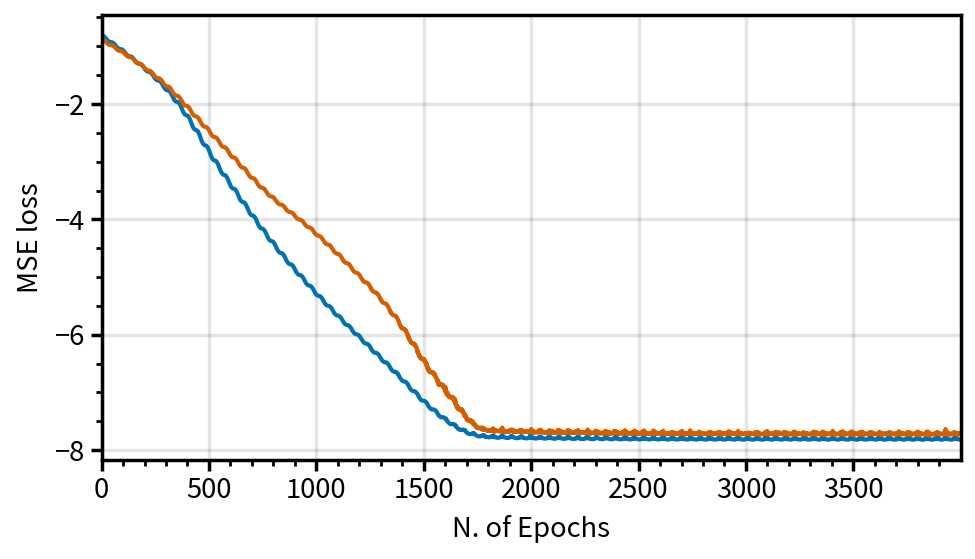

In [26]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig, ax1 = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.931,share=False)
ax1.plot(np.log10(losses[0]['train'][:]),label='training loss')
ax1.plot(np.log10(losses[0]['val'][:]),label='valid loss')
ax1.format(xlabel='N. of Epochs', ylabel='log10(MSE loss)')
plt.savefig('./analysis/pic/lossdiagram.png',dpi=400)
plt.show()

In [78]:
! pip install torch_optimizer

     |████████████████████████████████| 61 kB 10 kB/s  eta 0:00:011


In [58]:
def myMSE(tensorX=None, tensorY=None, model=None, pcastore=None,var=[varu,varv,varw,varth]):
    def myscore(y_pred, y, var_y):
        #var_y = torch.var(y, unbiased=False)
        return (np.sum((y - y_pred)**2)) / var_y #mse/var
    
    utru = np.dot(tensorY.detach().numpy()[:,:26],pcastore['u'].components_[:26])
    upre = np.dot(model(tensorX).detach().numpy()[:,:26],pcastore['u'].components_[:26])
    vtru = np.dot(tensorY.detach().numpy()[:,26:26+18],pcastore['v'].components_[:18])
    vpre = np.dot(model(tensorX).detach().numpy()[:,26:26+18],pcastore['v'].components_[:18])
    wtru = np.dot(tensorY.detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
    wpre = np.dot(model(tensorX).detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
    thtru = np.dot(tensorY.detach().numpy()[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
    thpre = np.dot(model(tensorX).detach().numpy()[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
    
    umse = myscore(upre,utru,var[0])
    vmse = myscore(vpre,vtru,var[1])
    wmse = myscore(wpre,wtru,var[2])
    thmse = myscore(thpre,thtru,var[3])
    return (umse+vmse+wmse+thmse)/4, umse,vmse,wmse,thmse

In [59]:
trainu_losses[-1],trainv_losses[-1],trainw_losses[-1],trainth_losses[-1],train_losses[-1]

(1195322.427734375,
 612982.1281738281,
 21422826.21875,
 880272.7783203125,
 66240.11946256868)

In [35]:
myMSE(tensorX=train_Xtensor, tensorY=train_ytensor, model=model, pcastore=pcastore)

(63199537080.81876,
 90842320181.89835,
 10618086608.285873,
 150571363619.71063,
 766377913.3802272)

In [37]:
surfix = '1625'
torch.save(models, './tmp/torch_try/1025/1/models_lwswuv_1102_'+str(surfix)+'.pt')
read_and_proc.save_to_pickle('./tmp/torch_try/1025/1/losses_lwswuv_1102_'+str(surfix)+
                '.pkt',losses,'PICKLE')

In [74]:
#plt.plot([obj.detach().numpy() for obj in trainv_losses])
plt.plot(train_losses)
plt.plot(val_losses)
#plt.plot(val_NSEs)
plt.ylim(-2,1)
plt.show()

NameError: name 'train_losses' is not defined

In [119]:
aaaaaa_th = np.dot(test_ytensor.detach().numpy()[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
aaaaaa_w = np.dot(test_ytensor.detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
aaaaaa_v = np.dot(test_ytensor.detach().numpy()[:,26:26+18],pcastore['v'].components_[:18])
aaaaaa_u = np.dot(test_ytensor.detach().numpy()[:,:26],pcastore['u'].components_[:26])

In [120]:
bbbbbb_th = np.dot(model(test_Xtensor).detach().numpy()[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
bbbbbb_w = np.dot(model(test_Xtensor).detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
bbbbbb_v = np.dot(model(test_Xtensor).detach().numpy()[:,26:26+18],pcastore['v'].components_[:18])
bbbbbb_u = np.dot(model(test_Xtensor).detach().numpy()[:,:26],pcastore['u'].components_[:26])

In [108]:
def myr2(truth,pred):
    MSE = np.sum((truth-pred)**2)
    VAR = np.sum((truth-np.mean(truth))**2)
    return np.mean(1-MSE/VAR), MSE,VAR
myr2(aaaaaa,bbbbbb)

(0.37951426305479874, 8.465318223185857e-05, 0.00013643050466981933)

In [112]:
# v
myr2(aaaaaa,bbbbbb) 

(0.6406571144313491, 0.00023148038979969583, 0.0006441769103996147)

In [115]:
# w (var/error)
myr2(aaaaaa,bbbbbb)

(-21.816496008088382, 1.0253462547992716e-05, 4.4938813323298603e-07)

In [118]:
# theta
myr2(aaaaaa,bbbbbb)

(0.5462829087013954, 2.9929102560471313e-05, 6.596423880530894e-05)

#### No Early Stopping

In [146]:
# theta
myr2(aaaaaa,bbbbbb)

0.5539370425094943

In [143]:
# w
myr2(aaaaaa,bbbbbb)

-10.444096639815301

In [149]:
# v
myr2(aaaaaa,bbbbbb)

0.7852923241310666

In [152]:
# u
myr2(aaaaaa,bbbbbb)

0.36458807362049384